# Creation of Performance Diagram Results Figure

Here we will be creating the figure displaying the skill of the trained models by visualizing critical success index (CSI), false alarm ratio (FAR), bias, and probability of detection (POD). Curves will be generated for these scalar skill metrics by varying the probability threshold.

### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

Where the results csv data are stored.

In [2]:
results_directory = '/Users/molina/Desktop/lightning/'

Functions to be used for model evaluation. Not all functions are used here, but all functions are used in all figures (made by maria).

In [3]:
def perf_indx(y_actual, y_hat):
    """
    
    Parameters
    ----------
    y_actual : float
        Ground truth.
    y_hat : float
        Model output.

    Returns
    -------
    Indices of TP, FP, FN, TN.

    """
    TP_indx = []
    FP_indx = []
    FN_indx = []
    TN_indx = []
    for i in range(len(y_hat)): 
        # tp
        if y_actual[i]==y_hat[i]==1:
           TP_indx.append(i)
        # fp
        if y_hat[i]==1 and y_actual[i]==0:
           FP_indx.append(i)
        # fn
        if y_hat[i]==0 and y_actual[i]==1:
           FN_indx.append(i)
        # tn
        if y_actual[i]==y_hat[i]==0:
           TN_indx.append(i)

    return(np.array(TP_indx), np.array(FP_indx), 
           np.array(FN_indx), np.array(TN_indx))

def perf_measure(y_actual, y_hat):
    """
    
    Parameters
    ----------
    y_actual : float
        Ground truth.
    y_hat : float
        Model output.

    Returns
    -------
    Frequency of TP, FP, FN, TN.

    """
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for i in range(len(y_hat)): 
        # tp
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        # fp
        if y_hat[i]==1 and y_actual[i]==0:
           FP += 1
        # fn
        if y_hat[i]==0 and y_actual[i]==1:
           FN += 1
        # tn
        if y_actual[i]==y_hat[i]==0:
           TN += 1
    return(TP, FP, FN, TN)

def grab_values(filename, threshold=0.5, grab_indices=True, 
                directory=results_directory):
    """

    Parameters
    ----------
    filename : string
        Name of file.
    threshold: float.
        Threshold for binary label assignment.
    grab_indices: boolean.
        If true grab tp, tn, etc indices.
        If false grab tp, tn, etc total.

    Returns
    -------
    prob : float
        Model output.
    grnd : float
        Ground truth.
    tpi (tp) : int
        Indices of true positive (or values).
    fpi (fp) : int
        Indices of false positive (or values).
    fni (fn) : int
        Indices of false negative (or values).
    tni (tn) : int
        Indices of true negative (or values).

    """
    # load csv file
    df = pd.read_csv(f'{directory}{filename}')
    # grab class prediction
    prob = df['probability']
    # make class prediction binary
    prob = prob.where(prob>=threshold,0).where(prob<threshold,1)
    # grab ground truth
    grnd = df['ground_truth']
    if grab_indices:
        # assign category
        tpi, fpi, fni, tni = perf_indx(grnd, prob)
        return prob, grnd, tpi, fpi, fni, tni
    if not grab_indices:
        # assign category
        tp, fp, fn, tn = perf_measure(grnd, prob)
        return prob, grnd, tp, fp, fn, tn
    
    
def conf_matrix_hour_freq(tpi, fpi, fni, tni, grnd_hour):
    """

    Parameters
    ----------
    tpi : int
        True positive indices.
    fpi : int
        False positive indices.
    fni : int
        False negative indices.
    tni : int
        True negative indices.
    grnd_hour : int
        Hours of events.

    Returns
    -------
    tphr_freq : int
        Hourly frequencies of tp.
    fphr_freq : int
        Hourly frequencies of fp.
    fnhr_freq : int
        Hourly frequencies of fn.
    tnhr_freq : int
        Hourly frequencies of tn.

    """
    # find tp, tn, etc in ground truth hour data and grab the corresponding event hours
    tphr = grnd_hour[np.isin(grnd_hour.index.values, tpi)]
    fphr = grnd_hour[np.isin(grnd_hour.index.values, fpi)]
    fnhr = grnd_hour[np.isin(grnd_hour.index.values, fni)]
    tnhr = grnd_hour[np.isin(grnd_hour.index.values, tni)]
    
    # rearrange arrays for plotting, fill missing hours with zeros
    tphr_freq = tphr.value_counts().reindex(np.arange(0,24), fill_value=0)[13:].append(
                tphr.value_counts().reindex(np.arange(0,24), fill_value=0)[:13]).values
    fphr_freq = fphr.value_counts().reindex(np.arange(0,24), fill_value=0)[13:].append(
                fphr.value_counts().reindex(np.arange(0,24), fill_value=0)[:13]).values
    fnhr_freq = fnhr.value_counts().reindex(np.arange(0,24), fill_value=0)[13:].append(
                fnhr.value_counts().reindex(np.arange(0,24), fill_value=0)[:13]).values
    tnhr_freq = tnhr.value_counts().reindex(np.arange(0,24), fill_value=0)[13:].append(
                tnhr.value_counts().reindex(np.arange(0,24), fill_value=0)[:13]).values
    return tphr_freq, fphr_freq, fnhr_freq, tnhr_freq


def far_metric(tp, fp):
    """
    
    Parameters
    ----------
    tp : float
        True positive.
    fp : float
        False positive.

    Returns
    -------
    float
        False alarm ratio.

    """
    return fp/(tp + fp)


def csi_metric(tp, fp, fn):
    """

    Parameters
    ----------
    tp : float
        True positive.
    fp : float
        False positive.
    fn : float
        False negative.

    Returns
    -------
    float
        Critical success index.

    """
    return tp/(tp + fp + fn)


def pod_metric(tp, fn):
    """

    Parameters
    ----------
    tp : float
        True positive.
    fn : float
        False negative.

    Returns
    -------
    float
        Probability of detection.

    """
    return tp/(tp + fn)


def pofd_metric(fp, tn):
    """

    Parameters
    ----------
    fp : float
        False positive.
    tn : float
        True negative.

    Returns
    -------
    float
        Probability of false detection.

    """
    return fp/(fp + tn)


Create objects to use for performance diagram plots.

In [4]:
%%capture

# plot constants
ticks = np.arange(0, 1.01, 0.01)
sr_g, pod_g = np.meshgrid(ticks, ticks)
bias = pod_g / sr_g
csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)

Create the figure with six plots.

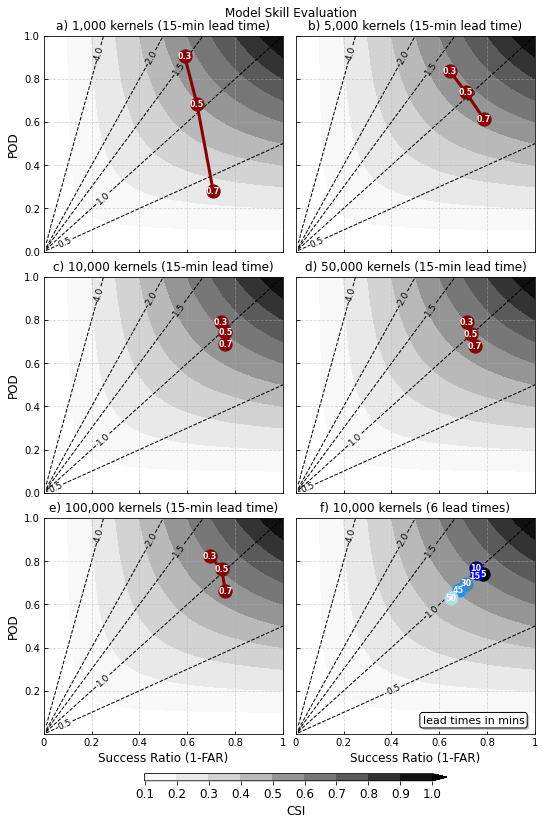

In [5]:
#-----------------------%

fig = plt.figure(figsize=(7.,10.))

fig.suptitle('Model Skill Evaluation', fontsize=12, x=0.49, y=1.01)

#-----------------------%

ax1 = fig.add_axes([0.0, 0.67, 0.475, 0.3])

ax1.set_title('a) 1,000 kernels (15-min lead time)', fontsize=12)

# set up 
csi_contour = ax1.contourf(sr_g, pod_g, csi, np.arange(0.1, 1.1, 0.1), extend="max", cmap="Greys")
b_contour = ax1.contour(sr_g, pod_g, bias, [0.5, 1, 1.5, 2, 4], colors="k", linestyles="dashed", linewidths=1.)
ax1.clabel(b_contour, inline=1, fontsize=9, inline_spacing=0, manual=False, fmt='%0.1f')

#-----------------------%

thresholds = [0.3,0.5,0.7]
sr_line = []
pd_line = []

for thresh in thresholds:

    # loading and computing needed variables from 1-100 kernel models.
    prob, grnd, tp, fp, fn, tn = grab_values('results_paper_1K_predictions.csv', threshold=thresh, grab_indices=False)
    
    ax1.scatter(1-far_metric(tp, fp), pod_metric(tp, fn), s=175, c='darkred', zorder=10)
    
    ax1.annotate(str(thresh),  xy=(1-far_metric(tp, fp), pod_metric(tp, fn)), 
                 color='white', weight='heavy', 
                 fontsize=8, zorder=120, 
                 horizontalalignment='center', verticalalignment='center')

    sr_line.append(1-far_metric(tp, fp))
    pd_line.append(pod_metric(tp, fn))

ax1.plot(sr_line, pd_line, c='darkred', lw=3.)

ax1.set_ylabel('POD', fontsize=12)

ax1.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax1.set_xticklabels([])
ax1.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax1.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0])

ax1.margins(x=0, y=0)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.tick_params(axis='x', which='both', direction='in', 
                bottom=True, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', direction='in', 
                left=True, right=False, labelleft=True)

#-----------------------%

ax2 = fig.add_axes([0.5, 0.67, 0.475, 0.3])

ax2.set_title('b) 5,000 kernels (15-min lead time)', fontsize=12)

# set up 
csi_contour = ax2.contourf(sr_g, pod_g, csi, np.arange(0.1, 1.1, 0.1), extend="max", cmap="Greys")
b_contour = ax2.contour(sr_g, pod_g, bias, [0.5, 1, 1.5, 2, 4], colors="k", linestyles="dashed", linewidths=1.)
ax2.clabel(b_contour, inline=1, fontsize=9, inline_spacing=0, manual=False, fmt='%0.1f')

sr_line = []
pd_line = []

for thresh in thresholds:

    # loading and computing needed variables from 1-100 kernel models.
    prob, grnd, tp, fp, fn, tn = grab_values('results_paper_5K_predictions.csv', threshold=thresh, grab_indices=False)
    
    ax2.scatter(1-far_metric(tp, fp), pod_metric(tp, fn), s=175, 
                c='darkred', zorder=10)
    
    ax2.annotate(str(thresh),  xy=(1-far_metric(tp, fp), pod_metric(tp, fn)), 
                 color='white', weight='heavy', 
                 fontsize=8, zorder=120, 
                 horizontalalignment='center', verticalalignment='center')

    sr_line.append(1-far_metric(tp, fp))
    pd_line.append(pod_metric(tp, fn))

ax2.plot(sr_line, pd_line, c='darkred', lw=3.)

ax2.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax2.set_xticklabels(['0',0.2,0.4,0.6,0.8,'1'])

ax2.set_yticks([0.2,0.4,0.6,0.8,1.0])
ax2.set_yticklabels([0.2,0.4,0.6,0.8,1.0])

ax2.margins(x=0, y=0)
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.tick_params(axis='x', which='both', direction='in', bottom=True, 
                top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', direction='in', left=True, 
                right=False, labelleft=False)


#-----------------------%

ax3 = fig.add_axes([0.0, 0.335, 0.475, 0.3])

ax3.set_title('c) 10,000 kernels (15-min lead time)', fontsize=12)

# set up 
csi_contour = ax3.contourf(sr_g, pod_g, csi, np.arange(0.1, 1.1, 0.1), extend="max", cmap="Greys")
b_contour = ax3.contour(sr_g, pod_g, bias, [0.5, 1, 1.5, 2, 4], colors="k", linestyles="dashed", linewidths=1.)
ax3.clabel(b_contour, inline=1, fontsize=9, inline_spacing=0, manual=False, fmt='%0.1f')

#-----------------------%

sr_line = []
pd_line = []

for thresh in thresholds:

    # loading and computing needed variables from 1-100 kernel models.
    prob, grnd, tp, fp, fn, tn = grab_values('results_paper_10K_predictions.csv', threshold=thresh, grab_indices=False)
    
    ax3.scatter(1-far_metric(tp, fp), pod_metric(tp, fn), s=175, c='darkred', zorder=10)
    
    ax3.annotate(str(thresh),  xy=(1-far_metric(tp, fp), pod_metric(tp, fn)), 
                 color='white', weight='heavy', 
                 fontsize=8, zorder=120, 
                 horizontalalignment='center', verticalalignment='center')

    sr_line.append(1-far_metric(tp, fp))
    pd_line.append(pod_metric(tp, fn))

ax3.plot(sr_line, pd_line, c='darkred', lw=3.)

ax3.set_ylabel('POD', fontsize=12)

ax3.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax3.set_xticklabels(['0',0.2,0.4,0.6,0.8,'1'])

ax3.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax3.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0])

ax3.margins(x=0, y=0)
ax3.grid(True, linestyle='--', alpha=0.5)
ax3.tick_params(axis='x', which='both', direction='in', bottom=True, 
                top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', direction='in', left=True, 
                right=False, labelleft=True)

#-----------------------%

ax4 = fig.add_axes([0.5, 0.335, 0.475, 0.3])

ax4.set_title('d) 50,000 kernels (15-min lead time)', fontsize=12)

# set up 
csi_contour = ax4.contourf(sr_g, pod_g, csi, np.arange(0.1, 1.1, 0.1), extend="max", cmap="Greys")
b_contour = ax4.contour(sr_g, pod_g, bias, [0.5, 1, 1.5, 2, 4], colors="k", linestyles="dashed", linewidths=1.)
ax4.clabel(b_contour, inline=1, fontsize=9, inline_spacing=0, manual=False, fmt='%0.1f')

sr_line = []
pd_line = []

for thresh in thresholds:

    # loading and computing needed variables from 1-100 kernel models.
    prob, grnd, tp, fp, fn, tn = grab_values('results_paper_50K_predictions.csv', threshold=thresh, grab_indices=False)
    
    ax4.scatter(1-far_metric(tp, fp), pod_metric(tp, fn), s=175, c='darkred', zorder=10)
    
    ax4.annotate(str(thresh),  xy=(1-far_metric(tp, fp), pod_metric(tp, fn)), 
                 color='white', weight='heavy', 
                 fontsize=8, zorder=120, 
                 horizontalalignment='center', verticalalignment='center')

    sr_line.append(1-far_metric(tp, fp))
    pd_line.append(pod_metric(tp, fn))

ax4.plot(sr_line, pd_line, c='darkred', lw=3.)

ax4.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax4.set_xticklabels(['0',0.2,0.4,0.6,0.8,'1'])

ax4.set_yticks([0.2,0.4,0.6,0.8,1.0])
ax4.set_yticklabels([0.2,0.4,0.6,0.8,1.0])

ax4.margins(x=0, y=0)
ax4.grid(True, linestyle='--', alpha=0.5)
ax4.tick_params(axis='x', which='both', direction='in', bottom=True, 
                top=False, labelbottom=False)
ax4.tick_params(axis='y', which='both', direction='in', left=True, 
                right=False, labelleft=False)


#-----------------------%

ax5 = fig.add_axes([0.0, 0.0, 0.475, 0.3])

ax5.set_title('e) 100,000 kernels (15-min lead time)', fontsize=12)

# set up 
csi_contour = ax5.contourf(sr_g, pod_g, csi, np.arange(0.1, 1.1, 0.1), extend="max", cmap="Greys")
b_contour = ax5.contour(sr_g, pod_g, bias, [0.5, 1, 1.5, 2, 4], colors="k", linestyles="dashed", linewidths=1.)
ax5.clabel(b_contour, inline=1, fontsize=9, inline_spacing=0, manual=False, fmt='%0.1f')

sr_line = []
pd_line = []

for thresh in thresholds:

    # loading and computing needed variables from 1-100 kernel models.
    prob, grnd, tp, fp, fn, tn = grab_values('results_paper_100K_predictions.csv', threshold=thresh, grab_indices=False)
    
    ax5.scatter(1-far_metric(tp, fp), pod_metric(tp, fn), s=175, c='darkred', zorder=10)
    
    ax5.annotate(str(thresh),  xy=(1-far_metric(tp, fp), pod_metric(tp, fn)), 
                 color='white', weight='heavy', 
                 fontsize=8, zorder=120, 
                 horizontalalignment='center', verticalalignment='center')

    sr_line.append(1-far_metric(tp, fp))
    pd_line.append(pod_metric(tp, fn))

ax5.plot(sr_line, pd_line, c='darkred', lw=3.)

ax5.set_xlabel('Success Ratio (1-FAR)', fontsize=12)
ax5.set_ylabel('POD', fontsize=12)

ax5.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax5.set_xticklabels(['0',0.2,0.4,0.6,0.8,'1'])

ax5.set_yticks([0.2,0.4,0.6,0.8,1.0])
ax5.set_yticklabels([0.2,0.4,0.6,0.8,1.0])

ax5.margins(x=0, y=0)
ax5.grid(True, linestyle='--', alpha=0.5)
ax5.tick_params(axis='x', which='both', direction='in', bottom=True, 
                top=False, labelbottom=True)
ax5.tick_params(axis='y', which='both', direction='in', left=True, 
                right=False, labelleft=True)

#-----------------------%

ax6 = fig.add_axes([0.5, 0.0, 0.475, 0.3])

ax6.set_title('f) 10,000 kernels (6 lead times)', fontsize=12)

# set up 
csi_contour = ax6.contourf(sr_g, pod_g, csi, np.arange(0.1, 1.1, 0.1), extend="max", cmap="Greys")
b_contour = ax6.contour(sr_g, pod_g, bias, [0.5, 1, 1.5, 2, 4], colors="k", linestyles="dashed", 
                        linewidths=1.)
ax6.clabel(b_contour, inline=1, fontsize=9, inline_spacing=0, manual=False, fmt='%0.1f')


leadtimes = ['5', '10', '30', '45', '50']
colors = ['k','navy', 'steelblue', 'dodgerblue', 'powderblue']

for ldtm, clr in zip(leadtimes, colors):

    # loading and computing needed variables from 1-100 kernel models.
    prob, grnd, tp, fp, fn, tn = grab_values(f'results_paper_10K_predictions_{ldtm}min.csv', threshold=0.5, grab_indices=False)
    
    ax6.scatter(1-far_metric(tp, fp), pod_metric(tp, fn), s=175, c=clr, zorder=10)
    
    ax6.annotate(str(ldtm),  xy=(1-far_metric(tp, fp), pod_metric(tp, fn)), 
                 color='white', weight='heavy', 
                 fontsize=8, zorder=120, 
                 horizontalalignment='center', verticalalignment='center')
    
    
# loading and computing needed variables from 1-100 kernel models.
prob, grnd, tp, fp, fn, tn = grab_values('results_paper_10K_predictions.csv', threshold=0.5, grab_indices=False)

ax6.scatter(1-far_metric(tp, fp), pod_metric(tp, fn), s=175, c='b', zorder=10)

ax6.annotate(str(15),  xy=(1-far_metric(tp, fp)-0.0125, pod_metric(tp, fn)-0.0125), 
             color='white', weight='heavy', 
             fontsize=8, zorder=120, 
             horizontalalignment='center', verticalalignment='center')


ax6.text(0.53, 0.05, 'lead times in mins', 
         fontsize=11, alpha=1., color='k', zorder=6, transform=ax6.transAxes,
         bbox=dict(facecolor='w', edgecolor='k', alpha=1., linewidth=1., 
                   boxstyle='round', pad=0.25, 
                   path_effects=[
                       path_effects.SimplePatchShadow(),path_effects.Normal()]))


ax6.set_xlabel('Success Ratio (1-FAR)', fontsize=12)
#ax6.set_ylabel('POD', fontsize=12)

ax6.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax6.set_xticklabels(['0',0.2,0.4,0.6,0.8,'1'])

ax6.set_yticks([0.2,0.4,0.6,0.8,1.0])
ax6.set_yticklabels([0.2,0.4,0.6,0.8,1.0])

ax6.margins(x=0, y=0)
ax6.grid(True, linestyle='--', alpha=0.5)
ax6.tick_params(axis='x', which='both', direction='in', bottom=True, 
                top=False, labelbottom=True)
ax6.tick_params(axis='y', which='both', direction='in', left=True, 
                right=False, labelleft=False)


#---csi colorbar
cbar_ax = fig.add_axes([0.2, -0.065, 0.6, 0.01])
ticks_1 = np.arange(0.1, 1.1, 0.1)
cbar = fig.colorbar(csi_contour, cax=cbar_ax, ticks=ticks_1[:], 
                    orientation='horizontal')
cbar.ax.set_xticklabels(['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0'])
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'CSI', fontsize=12) 
#---

#plt.savefig(f'{results_directory}performancefig1.png', bbox_inches='tight', dpi=500)
plt.show()

#-----------------------%

Now in horizontal orientation.

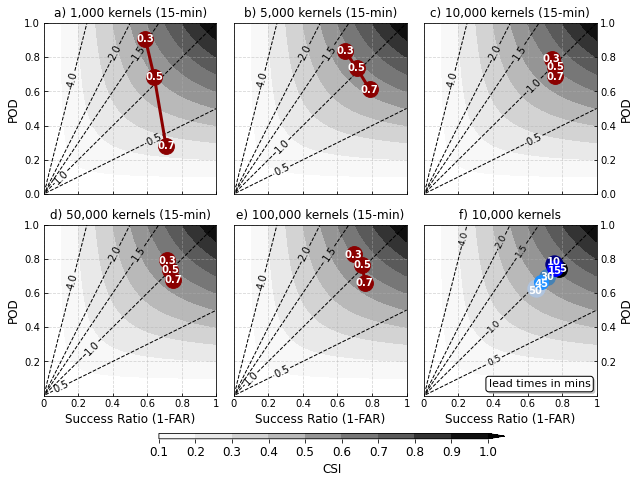

In [6]:
#---#---#---#---#---#---#---#---#---#---#---#---


fig = plt.figure(figsize=(8.,5.))

#---


ax1 = fig.add_axes([0.0, 0.5, 0.3, 0.475])

ax1.set_title('a) 1,000 kernels (15-min)', fontsize=12)

# set up 
csi_contour = ax1.contourf(sr_g, pod_g, csi, np.arange(0.1, 1.1, 0.1), extend="max", cmap="Greys")
b_contour = ax1.contour(sr_g, pod_g, bias, [0.5, 1, 1.5, 2, 4], colors="k", linestyles="dashed", 
                        linewidths=1.)
ax1.clabel(b_contour, inline=1, fontsize=10, inline_spacing=0, manual=False, fmt='%0.1f')

#-----------------------%

thresholds = [0.3,0.5,0.7]
sr_line = []
pd_line = []

for thresh in thresholds:

    # loading and computing needed variables from 1-100 kernel models.
    prob, grnd, tp, fp, fn, tn = grab_values('results_paper_1K_predictions.csv', threshold=thresh, grab_indices=False)
    
    ax1.scatter(1-far_metric(tp, fp), pod_metric(tp, fn), s=250, c='darkred', zorder=10)
    
    ax1.annotate(str(thresh),  xy=(1-far_metric(tp, fp), pod_metric(tp, fn)), 
                 color='white', weight='heavy', 
                 fontsize=10, zorder=120, 
                 horizontalalignment='center', verticalalignment='center')

    sr_line.append(1-far_metric(tp, fp))
    pd_line.append(pod_metric(tp, fn))

ax1.plot(sr_line, pd_line, c='darkred', lw=3.)

ax1.set_ylabel('POD', fontsize=12)

ax1.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax1.set_xticklabels([])
ax1.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax1.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0])

ax1.margins(x=0, y=0)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.tick_params(axis='x', which='both', direction='in', 
                bottom=True, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', direction='in', 
                left=True, right=False, labelleft=True)


#-----------------------%


ax2 = fig.add_axes([0.33, 0.5, 0.3, 0.475])

ax2.set_title('b) 5,000 kernels (15-min)', fontsize=12)

# set up 
csi_contour = ax2.contourf(sr_g, pod_g, csi, np.arange(0.1, 1.1, 0.1), extend="max", cmap="Greys")
b_contour = ax2.contour(sr_g, pod_g, bias, [0.5, 1, 1.5, 2, 4], colors="k", linestyles="dashed", linewidths=1.)
ax2.clabel(b_contour, inline=1, fontsize=10, inline_spacing=0, manual=False, fmt='%0.1f')

sr_line = []
pd_line = []

for thresh in thresholds:

    # loading and computing needed variables from 1-100 kernel models.
    prob, grnd, tp, fp, fn, tn = grab_values('results_paper_5K_predictions.csv', threshold=thresh, grab_indices=False)
    
    ax2.scatter(1-far_metric(tp, fp), pod_metric(tp, fn), s=250, 
                c='darkred', zorder=10)
    
    ax2.annotate(str(thresh),  xy=(1-far_metric(tp, fp), pod_metric(tp, fn)), 
                 color='white', weight='heavy', 
                 fontsize=10, zorder=120, 
                 horizontalalignment='center', verticalalignment='center')

    sr_line.append(1-far_metric(tp, fp))
    pd_line.append(pod_metric(tp, fn))

ax2.plot(sr_line, pd_line, c='darkred', lw=3.)

#ax2.set_xlabel('Success Ratio (1-FAR)', fontsize=12)
#ax2.set_ylabel('POD', fontsize=12)

ax2.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax2.set_xticklabels(['0',0.2,0.4,0.6,0.8,'1'])

ax2.set_yticks([0.2,0.4,0.6,0.8,1.0])
ax2.set_yticklabels([0.2,0.4,0.6,0.8,1.0])

ax2.margins(x=0, y=0)
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.tick_params(axis='x', which='both', direction='in', bottom=True, 
                top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', direction='in', left=False, 
                right=False, labelleft=False)


#-----------------------%


ax3 = fig.add_axes([0.66, 0.5, 0.3, 0.475])

ax3.set_title('c) 10,000 kernels (15-min)', fontsize=12)

# set up 
csi_contour = ax3.contourf(sr_g, pod_g, csi, np.arange(0.1, 1.1, 0.1), extend="max", cmap="Greys")
b_contour = ax3.contour(sr_g, pod_g, bias, [0.5, 1, 1.5, 2, 4], colors="k", linestyles="dashed", linewidths=1.)
ax3.clabel(b_contour, inline=1, fontsize=10, inline_spacing=0, manual=False, fmt='%0.1f')

#-----------------------%

sr_line = []
pd_line = []

for thresh in thresholds:

    # loading and computing needed variables from 1-100 kernel models.
    prob, grnd, tp, fp, fn, tn = grab_values('results_paper_10K_predictions.csv', threshold=thresh, grab_indices=False)
    
    ax3.scatter(1-far_metric(tp, fp), pod_metric(tp, fn), s=250, c='darkred', zorder=10)
    
    ax3.annotate(str(thresh),  xy=(1-far_metric(tp, fp), pod_metric(tp, fn)), 
                 color='white', weight='heavy', 
                 fontsize=10, zorder=120, 
                 horizontalalignment='center', verticalalignment='center')

    sr_line.append(1-far_metric(tp, fp))
    pd_line.append(pod_metric(tp, fn))

ax3.plot(sr_line, pd_line, c='darkred', lw=3.)

ax3.set_ylabel('POD', fontsize=12)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()

ax3.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax3.set_xticklabels(['0',0.2,0.4,0.6,0.8,'1'])

ax3.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax3.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0])

ax3.margins(x=0, y=0)
ax3.grid(True, linestyle='--', alpha=0.5)
ax3.tick_params(axis='x', which='both', direction='in', bottom=True, 
                top=False, labelbottom=False)
ax3.tick_params(axis='y', which='both', direction='in', left=False, 
                right=True, labelleft=False, labelright=True)

#-----------------------%


ax4 = fig.add_axes([0., -0.06,  0.3, 0.475])

ax4.set_title('d) 50,000 kernels (15-min)', fontsize=12)

# set up 
csi_contour = ax4.contourf(sr_g, pod_g, csi, np.arange(0.1, 1.1, 0.1), extend="max", cmap="Greys")
b_contour = ax4.contour(sr_g, pod_g, bias, [0.5, 1, 1.5, 2, 4], colors="k", linestyles="dashed", linewidths=1.)
ax4.clabel(b_contour, inline=1, fontsize=10, inline_spacing=0, manual=False, fmt='%0.1f')

sr_line = []
pd_line = []

for thresh in thresholds:

    # loading and computing needed variables from 1-100 kernel models.
    prob, grnd, tp, fp, fn, tn = grab_values('results_paper_50K_predictions.csv', threshold=thresh, grab_indices=False)
    
    ax4.scatter(1-far_metric(tp, fp), pod_metric(tp, fn), s=250, c='darkred', zorder=10)
    
    ax4.annotate(str(thresh),  xy=(1-far_metric(tp, fp), pod_metric(tp, fn)), 
                 color='white', weight='heavy', 
                 fontsize=10, zorder=120, 
                 horizontalalignment='center', verticalalignment='center')

    sr_line.append(1-far_metric(tp, fp))
    pd_line.append(pod_metric(tp, fn))

ax4.plot(sr_line, pd_line, c='darkred', lw=3.)

ax4.set_xlabel('Success Ratio (1-FAR)', fontsize=12)
ax4.set_ylabel('POD', fontsize=12)

ax4.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax4.set_xticklabels(['0',0.2,0.4,0.6,0.8,'1'])

ax4.set_yticks([0.2,0.4,0.6,0.8,1.0])
ax4.set_yticklabels([0.2,0.4,0.6,0.8,1.0])

ax4.margins(x=0, y=0)
ax4.grid(True, linestyle='--', alpha=0.5)
ax4.tick_params(axis='x', which='both', direction='in', bottom=True, 
                top=False, labelbottom=True)
ax4.tick_params(axis='y', which='both', direction='in', left=True, 
                right=False, labelleft=True)


#-----------------------%


ax5 = fig.add_axes([0.33, -0.06,  0.3, 0.475])

ax5.set_title('e) 100,000 kernels (15-min)', fontsize=12)

# set up 
csi_contour = ax5.contourf(sr_g, pod_g, csi, np.arange(0.1, 1.1, 0.1), extend="max", cmap="Greys")
b_contour = ax5.contour(sr_g, pod_g, bias, [0.5, 1, 1.5, 2, 4], colors="k", linestyles="dashed", linewidths=1.)
ax5.clabel(b_contour, inline=1, fontsize=10, inline_spacing=0, manual=False, fmt='%0.1f')

sr_line = []
pd_line = []

for thresh in thresholds:

    # loading and computing needed variables from 1-100 kernel models.
    prob, grnd, tp, fp, fn, tn = grab_values('results_paper_100K_predictions.csv', threshold=thresh, grab_indices=False)
    
    ax5.scatter(1-far_metric(tp, fp), pod_metric(tp, fn), s=250, c='darkred', zorder=10)
    
    ax5.annotate(str(thresh),  xy=(1-far_metric(tp, fp), pod_metric(tp, fn)), 
                 color='white', weight='heavy', 
                 fontsize=10, zorder=120, 
                 horizontalalignment='center', verticalalignment='center')

    sr_line.append(1-far_metric(tp, fp))
    pd_line.append(pod_metric(tp, fn))

ax5.plot(sr_line, pd_line, c='darkred', lw=3.)

ax5.set_xlabel('Success Ratio (1-FAR)', fontsize=12)
#ax5.set_ylabel('POD', fontsize=12)

ax5.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax5.set_xticklabels(['0',0.2,0.4,0.6,0.8,'1'])

ax5.set_yticks([0.2,0.4,0.6,0.8,1.0])
ax5.set_yticklabels([0.2,0.4,0.6,0.8,1.0])

ax5.margins(x=0, y=0)
ax5.grid(True, linestyle='--', alpha=0.5)
ax5.tick_params(axis='x', which='both', direction='in', bottom=True, 
                top=False, labelbottom=True)
ax5.tick_params(axis='y', which='both', direction='in', left=False, 
                right=False, labelleft=False)



#-----------------------%


ax6 = fig.add_axes([0.66, -0.06, 0.3, 0.475])

ax6.set_title('f) 10,000 kernels', fontsize=12)

# set up 
csi_contour = ax6.contourf(sr_g, pod_g, csi, np.arange(0.1, 1.1, 0.1), extend="max", cmap="Greys")
b_contour = ax6.contour(sr_g, pod_g, bias, [0.5, 1, 1.5, 2, 4], colors="k", linestyles="dashed", 
                        linewidths=1.)
ax6.clabel(b_contour, inline=1, fontsize=9, inline_spacing=0, manual=False, fmt='%0.1f')


leadtimes = ['30']
colors = ['steelblue']

for ldtm, clr in zip(leadtimes, colors):

    # loading and computing needed variables from 1-100 kernel models.
    prob, grnd, tp, fp, fn, tn = grab_values(f'results_paper_10K_predictions_{ldtm}min.csv', threshold=0.5, grab_indices=False)
    
    ax6.scatter(1-far_metric(tp, fp), pod_metric(tp, fn), s=250, c=clr, zorder=10)
    
    ax6.annotate(str(ldtm),  xy=(1-far_metric(tp, fp), pod_metric(tp, fn)), 
                 color='white', weight='heavy', 
                 fontsize=10, zorder=120, 
                 horizontalalignment='center', verticalalignment='center')
    
    
# loading and computing needed variables from 1-100 kernel models.
prob, grnd, tp, fp, fn, tn = grab_values('results_paper_10K_predictions_50min.csv', threshold=0.5, grab_indices=False)

ax6.scatter(1-far_metric(tp, fp), pod_metric(tp, fn), s=300, c='lightsteelblue', zorder=10)

ax6.annotate(str(50),  xy=(1-far_metric(tp, fp), pod_metric(tp, fn)-0.015), 
             color='white', weight='heavy', 
             fontsize=10, zorder=120, 
             horizontalalignment='center', verticalalignment='center')




    
# loading and computing needed variables from 1-100 kernel models.
prob, grnd, tp, fp, fn, tn = grab_values('results_paper_10K_predictions_5min.csv', threshold=0.5, grab_indices=False)

ax6.scatter(1-far_metric(tp, fp), pod_metric(tp, fn), s=250, c='k', zorder=10)

ax6.annotate(str(5),  xy=(1-far_metric(tp, fp)+0.02, pod_metric(tp, fn)), 
             color='white', weight='heavy', 
             fontsize=10, zorder=120, 
             horizontalalignment='center', verticalalignment='center')


prob, grnd, tp, fp, fn, tn = grab_values('results_paper_10K_predictions_10min.csv', threshold=0.5, grab_indices=False)

ax6.scatter(1-far_metric(tp, fp), pod_metric(tp, fn), s=300, c='navy', zorder=10)

ax6.annotate(str(10),  xy=(1-far_metric(tp, fp), pod_metric(tp, fn)+0.0125), 
             color='white', weight='heavy', 
             fontsize=10, zorder=120, 
             horizontalalignment='center', verticalalignment='center')
    
    
# loading and computing needed variables from 1-100 kernel models.
prob, grnd, tp, fp, fn, tn = grab_values('results_paper_10K_predictions.csv', threshold=0.5, grab_indices=False)

ax6.scatter(1-far_metric(tp, fp), pod_metric(tp, fn), s=250, c='b', zorder=10)

ax6.annotate(str(15),  xy=(1-far_metric(tp, fp)-0.0025, pod_metric(tp, fn)-0.014), 
             color='white', weight='heavy', 
             fontsize=10, zorder=120, 
             horizontalalignment='center', verticalalignment='center')


# loading and computing needed variables from 1-100 kernel models.
prob, grnd, tp, fp, fn, tn = grab_values('results_paper_10K_predictions_45min.csv', threshold=0.5, grab_indices=False)

ax6.scatter(1-far_metric(tp, fp), pod_metric(tp, fn), s=200, c='dodgerblue', zorder=10)

ax6.annotate(str(45),  xy=(1-far_metric(tp, fp), pod_metric(tp, fn)-0.0125), 
             color='white', weight='heavy', 
             fontsize=10, zorder=120, 
             horizontalalignment='center', verticalalignment='center')


ax6.text(0.375, 0.05, 'lead times in mins', 
         fontsize=11, alpha=1., color='k', zorder=6, transform=ax6.transAxes,
         bbox=dict(facecolor='w', edgecolor='k', alpha=1., linewidth=1., 
                   boxstyle='round', pad=0.25, 
                   path_effects=[
                       path_effects.SimplePatchShadow(),path_effects.Normal()]))


ax6.set_xlabel('Success Ratio (1-FAR)', fontsize=12)
ax6.set_ylabel('POD', fontsize=12)
ax6.yaxis.set_label_position("right")
ax6.yaxis.tick_right()

ax6.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax6.set_xticklabels(['0',0.2,0.4,0.6,0.8,'1'])

ax6.set_yticks([0.2,0.4,0.6,0.8,1.0])
ax6.set_yticklabels([0.2,0.4,0.6,0.8,1.0])

ax6.margins(x=0, y=0)
ax6.grid(True, linestyle='--', alpha=0.5)
ax6.tick_params(axis='x', which='both', direction='in', bottom=True, 
                top=False, labelbottom=True)
ax6.tick_params(axis='y', which='both', direction='in', left=False, 
                right=True, labelleft=False, labelright=True)


#---csi colorbar
cbar_ax = fig.add_axes([0.2, -0.18, 0.6, 0.015])
ticks_1 = np.arange(0.1, 1.1, 0.1)
cbar = fig.colorbar(csi_contour, cax=cbar_ax, ticks=ticks_1[:], 
                    orientation='horizontal')
cbar.ax.set_xticklabels(['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0'])
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'CSI', fontsize=12) 
#---

#plt.savefig(f'{results_directory}performancefig1.png', bbox_inches='tight', dpi=500)
plt.show()

#---